# Appendinx

This file contains code required to make the repository self contained, but these materials are not part of the workshop.

### Building the datasets

The output of the scraping is a single JSON lines file, witht the scrapping of the different pages. In this section, the rows from each page are splitted and saved in different files for the workshop.

In [1]:
import pandas

imdb = pandas.read_json('data/data_with_bio.jl.bz2', lines=True)

In [2]:
MOVIE_LIST_FIELDS =[
    'imdb_id',
    'title',
    'summary',
    'year',
    'rating',
    'gross',
]
imdb['year'] = imdb['year'].str.extract('\((\d{4})\)$', expand=False)
imdb[imdb.source == 'list'][MOVIE_LIST_FIELDS].to_csv('data/movies_from_list.csv.gz',
                                                      sep=';',
                                                      index=False,
                                                      compression='gzip')

In [3]:
MOVIE_DETAIL_FIELDS = [
    'imdb_id',
    'storyline',
    'photo',
    'release_date',
    'country',
    'language',
    'genres',
    'color',
    'runtime',
    'certificate',
    'production_co',
    'rate',
    'num_ratings',
    'plot_keywords',
    'cast'
]
imdb['color'] = imdb['color'].replace({'ColorColor': 'Color',
                                       'ColorColorColor': 'Color',
                                       'Black and White Black and White': 'Black and White'})
imdb['color'] = imdb['color'].where(imdb.color.isin(['Color', 'Black and White']), float('NaN'))
(imdb[imdb.source == 'movie'][MOVIE_DETAIL_FIELDS].drop_duplicates(subset=['imdb_id'])
                                                  .set_index('imdb_id')
                                                  .to_json('data/movies_from_detail.json.bz2',
                                                           compression='bz2'))

### Part I: Loading, exploring and cleaning data

Load data

In [4]:
import os

MOVIES_LIST_FNAME = os.path.join('data', 'movies_from_list.csv.gz')
MOVIES_DETAIL_FNAME = os.path.join('data', 'movies_from_detail.json.bz2')

In [5]:
movies_list = pandas.read_csv(MOVIES_LIST_FNAME, sep=';')
movies_detail = pandas.read_json(MOVIES_DETAIL_FNAME)

Exploring

In [6]:
movies_list.head()

,imdb_id,title,summary,year,rating,gross
0,tt5474036,Husband Material,The film is a love story set in Punjab where A...,2018.0,7.0,5.0
1,tt5970844,Thugs of Hindostan,NaN,2018.0,NaN,NaN
2,tt8108202,Stree,"In the small town of Chanderi, the menfolk liv...",2018.0,8.3,NaN
3,tt7720922,Batti Gul Meter Chalu,A social movie about escalating electric bills.,2018.0,6.4,1.0
4,tt5080556,2.0,Dr. Vaseegaran is forced to reassemble Chitti ...,2018.0,NaN,NaN


In [7]:
movies_detail.tail(3).T

,tt9056988,tt9059202,tt9060700
storyline,Later they realise that the game has turned ab...,None,None
photo,None,None,None
release_date,2018 (India),30 September 2018 (India),February 2019 (India)
country,[India],[India],[India]
language,[Hindi],[Hindi],[Hindi]
genres,[Horror],[Drama],[Drama]
color,Color,Color,Color
runtime,None,65 min,90 min
certificate,None,None,None
production_co,[],[],"[Golden Triangle Charity Trust, Sylph Producti..."


In [8]:
movies_list.describe()

,year,rating,gross
count,9823.000000,5747.000000,454.000000
mean,1997.417490,5.947486,3.572687
std,14.036789,1.411049,2.470623
min,1970.000000,1.600000,1.000000
25%,1986.000000,5.000000,1.000000
50%,1999.000000,6.100000,3.000000
75%,2010.000000,7.000000,5.000000
max,2020.000000,10.000000,9.000000


In [9]:
movies_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 6 columns):
imdb_id    10044 non-null object
title      10044 non-null object
summary    6128 non-null object
year       9823 non-null float64
rating     5747 non-null float64
gross      454 non-null float64
dtypes: float64(3), object(3)
memory usage: 470.9+ KB


Combining datasets

In [10]:
movies_list.shape

(10044, 6)

In [11]:
movies_list['imdb_id'].nunique()

9894

In [12]:
movies_list = movies_list.drop_duplicates(subset=['imdb_id'])

In [13]:
movies = movies_list.join(movies_detail, on='imdb_id', how='inner')

In [14]:
movies = movies.set_index('imdb_id')

In [15]:
movies.shape

(9857, 19)

In [16]:
movies.head(3).T

imdb_id,tt5474036,tt5970844,tt8108202
title,Husband Material,Thugs of Hindostan,Stree
summary,The film is a love story set in Punjab where A...,NaN,"In the small town of Chanderi, the menfolk liv..."
year,2018,2018,2018
rating,7,NaN,8.3
gross,5,NaN,NaN
storyline,The film is a love story set in Punjab where A...,None,Chanderi village is haunted for years by a wit...
photo,https://m.media-amazon.com/images/M/MV5BNTU3Zj...,https://m.media-amazon.com/images/M/MV5BMTA3OD...,https://m.media-amazon.com/images/M/MV5BMjk4NG...
release_date,14 September 2018 (USA),8 November 2018 (India),31 August 2018 (USA)
country,[India],[India],[India]
language,[Hindi],"[Hindi, Tamil, Telugu]",[Hindi]


Selecting data

In [17]:
movies.loc['tt2905838', 'storyline']

"A chance encounter of the unassuming bank receptionist Harleen Sahni with the charming yet mysterious Rajveer Nanda, results in an on-rush of ditched planes, car chases, shoot-outs, bombing raids and general global mayhem. But as the transcontinental chase ensues with Rajveer convincing Harleen that he's the good guy, can she really trust him, and will trust matter when the bullets start flying?"

In [18]:
movies.head()

,title,summary,year,rating,gross,storyline,photo,release_date,country,language,genres,color,runtime,certificate,production_co,rate,num_ratings,plot_keywords,cast
imdb_id,,,,,,,,,,,,,,,,,,,
tt5474036,Husband Material,The film is a love story set in Punjab where A...,2018.0,7.0,5.0,The film is a love story set in Punjab where A...,https://m.media-amazon.com/images/M/MV5BNTU3Zj...,14 September 2018 (USA),[India],[Hindi],[Romance],Color,156 min,12A|\n »,[Colour Yellow Productions],7.0,"1,756",None,"[{'imdb_id': 'nm3966456', 'name': 'Tapsee Pann..."
tt5970844,Thugs of Hindostan,NaN,2018.0,NaN,NaN,None,https://m.media-amazon.com/images/M/MV5BMTA3OD...,8 November 2018 (India),[India],"[Hindi, Tamil, Telugu]","[Action, Adventure]",Color,None,None,[],NaN,None,[based on novel],"[{'imdb_id': 'nm0451148', 'name': 'Aamir Khan'..."
tt8108202,Stree,"In the small town of Chanderi, the menfolk liv...",2018.0,8.3,NaN,Chanderi village is haunted for years by a wit...,https://m.media-amazon.com/images/M/MV5BMjk4NG...,31 August 2018 (USA),[India],[Hindi],"[Comedy, Horror]",Color,128 min,15|\n »,[D2R Films],8.3,"7,531","[father son relationship, friendship, prostitu...","[{'imdb_id': 'nm3822770', 'name': 'Rajkummar R..."
tt7720922,Batti Gul Meter Chalu,A social movie about escalating electric bills.,2018.0,6.4,1.0,"S.K, Nauti, and Tripathi are childhood friends...",https://m.media-amazon.com/images/M/MV5BNzdiNW...,21 September 2018 (USA),[India],[Hindi],[Drama],Color,161 min,PG|\n »,[Krti Pictures],6.4,"1,410",None,"[{'imdb_id': 'nm1372788', 'name': 'Shahid Kapo..."
tt5080556,2.0,Dr. Vaseegaran is forced to reassemble Chitti ...,2018.0,NaN,NaN,Dr. Vaseegaran is forced to reassemble Chitti ...,https://m.media-amazon.com/images/M/MV5BZDE4MG...,29 November 2018 (India),[India],"[Tamil, Telugu, Hindi]","[Action, Sci-Fi, Thriller]",Color,None,None,[Dakshaa],NaN,None,"[sequel, robot]","[{'imdb_id': 'nm0707425', 'name': 'Rajinikanth..."


In [19]:
movies[(movies.rate > 9.5) & (movies.title.str.startswith('K'))]

,title,summary,year,rating,gross,storyline,photo,release_date,country,language,genres,color,runtime,certificate,production_co,rate,num_ratings,plot_keywords,cast
imdb_id,,,,,,,,,,,,,,,,,,,
tt8551394,Kathor,Neelkanth chaturvedi is 55 years old . He is a...,2018.0,9.6,NaN,Neelkanth chaturvedi is 55 years old . He is a...,https://m.media-amazon.com/images/M/MV5BNDhkNW...,2018 (India),[India],[Hindi],[Drama],Color,None,None,[],9.6,5,None,"[{'imdb_id': 'nm1391032', 'name': 'Lalit Parim..."
tt9059202,Kuch Der Aur,NaN,2018.0,10.0,NaN,None,None,30 September 2018 (India),[India],[Hindi],[Drama],Color,65 min,None,[],10.0,5,None,"[{'imdb_id': 'nm10156491', 'name': 'Meenu Kawa..."


Checking data

In [20]:
movies[['rate', 'rating']].head()

,rate,rating
imdb_id,,
tt5474036,7.0,7.0
tt5970844,NaN,NaN
tt8108202,8.3,8.3
tt7720922,6.4,6.4
tt5080556,NaN,NaN


In [21]:
movies['rate'].equals(movies['rating'])

False

In [22]:
rates = movies[['rate', 'rating']]
rates.min()

rate      1.6
rating    1.6
dtype: float64

In [23]:
rates = rates.fillna(0.)
(rates['rate'] != rates['rating']).sum()

3

In [24]:
movies.loc[rates['rate'] != rates['rating'], ['title', 'rate', 'rating']]

,title,rate,rating
imdb_id,,,
tt4232066,Once Again,7.4,7.5
tt8396128,Pataakha,7.9,8.0
tt2344678,Brave Man,1.7,1.7


In [25]:
del movies['rating']

Extracting information

In [26]:
movies['num_ratings'].head()

imdb_id
tt5474036    1,756
tt5970844     None
tt8108202    7,531
tt7720922    1,410
tt5080556     None
Name: num_ratings, dtype: object

In [27]:
movies['num_ratings'] = movies['num_ratings'].str.replace(',', '').astype(float)
movies['num_ratings'].head()

imdb_id
tt5474036    1756.0
tt5970844       NaN
tt8108202    7531.0
tt7720922    1410.0
tt5080556       NaN
Name: num_ratings, dtype: float64

In [28]:
movies['release_date'] = pandas.to_datetime(movies['release_date'].str.extract('^(\d+ \w+ \d+)', expand=False))
movies['release_date'].head()

imdb_id
tt5474036   2018-09-14
tt5970844   2018-11-08
tt8108202   2018-08-31
tt7720922   2018-09-21
tt5080556   2018-11-29
Name: release_date, dtype: datetime64[ns]

In [29]:
movies['runtime'] = movies['runtime'].str.extract('(\d+) min$', expand=False).astype(float)

In [30]:
movies.head(1).reset_index().to_json(orient='records', lines=True)

'{"imdb_id":"tt5474036","title":"Husband Material","summary":"The film is a love story set in Punjab where Abhishek Bachchan, Taapsee Pannu, and Vicky Kaushal will be seen in prominent roles.","year":2018.0,"gross":5.0,"storyline":"The film is a love story set in Punjab where Abhishek Bachchan, Taapsee Pannu, and Vicky Kaushal will be seen in prominent roles.","photo":"https:\\/\\/m.media-amazon.com\\/images\\/M\\/MV5BNTU3ZjEzMTYtYThjMC00ZjljLWJjYjEtZGU5M2U5ODcwNTY4XkEyXkFqcGdeQXVyNTE4ODU0NzA@._V1_UX182_CR0,0,182,268_AL_.jpg","release_date":1536883200000,"country":["India"],"language":["Hindi"],"genres":["Romance"],"color":"Color","runtime":156.0,"certificate":"12A|\\n\\u00a0\\u00bb","production_co":["Colour Yellow Productions"],"rate":7.0,"num_ratings":1756.0,"plot_keywords":null,"cast":[{"imdb_id":"nm3966456","name":"Tapsee Pannu","link":"\\/name\\/nm3966456\\/?ref_=tt_cl_t1"},{"imdb_id":"nm5817249","name":"Vicky Kaushal","link":"\\/name\\/nm5817249\\/?ref_=tt_cl_t2"},{"imdb_id":"nm0

In [31]:
movies.reset_index().to_json('data/movies_clean.jsonl.bz2', orient='records', lines=True, compression='bz2')

### Part II: Data analysis

Highest rated movies

In [32]:
movies.sort_values('rate', ascending=False).head(10)[['title', 'rate', 'num_ratings', 'release_date']]

,title,rate,num_ratings,release_date
imdb_id,,,,
tt9059202,Kuch Der Aur,10.0,5.0,2018-09-30
tt7028460,Three and a Half,9.7,95.0,2018-07-17
tt8551394,Kathor,9.6,5.0,NaT
tt4946222,Man on Mission Fauladi,9.4,64.0,2004-01-01
tt8453246,Jhakaas!,9.4,5.0,2018-09-13
tt7282370,Who,9.4,19.0,2018-10-25
tt4944418,Man On Mission Jaanbaaz,9.4,68.0,2005-01-01
tt5963908,T for Taj Mahal,9.3,71.0,2018-06-23
tt8080354,Mitti-back to roots,9.3,30.0,2018-01-26


In [33]:
%timeit movies.nlargest(10, 'rate')

7.97 ms ± 548 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
%timeit movies.sort_values('rate', ascending=False).head(10)

6.14 ms ± 94.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
movies['num_ratings'].describe()

count      5609.000000
mean       1866.771617
std       12248.980281
min           5.000000
25%          18.000000
50%          68.000000
75%         521.000000
max      722712.000000
Name: num_ratings, dtype: float64

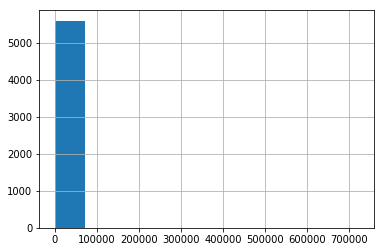

In [36]:
%matplotlib inline
movies['num_ratings'].hist()

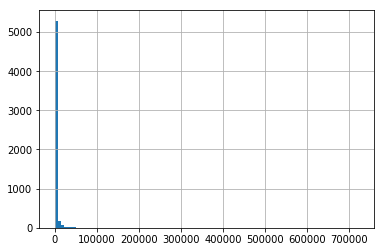

In [37]:
movies['num_ratings'].hist(bins=100)

In [38]:
movies[['rate', 'num_ratings']].corr()

,rate,num_ratings
rate,1.000000,0.127945
num_ratings,0.127945,1.000000


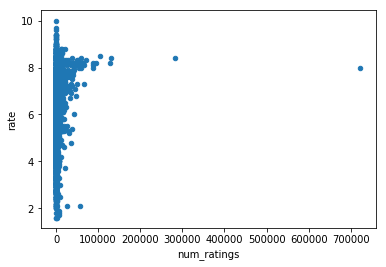

In [39]:
movies.plot(kind='scatter', x='num_ratings', y='rate')

In [40]:
movies.nlargest(5, 'num_ratings')

,title,summary,year,gross,storyline,photo,release_date,country,language,genres,color,runtime,certificate,production_co,rate,num_ratings,plot_keywords,cast
imdb_id,,,,,,,,,,,,,,,,,,
tt1010048,Slumdog Millionaire,A Mumbai teen reflects on his upbringing in th...,2008.0,1.0,"The story of Jamal Malik, an 18 year-old orpha...",https://m.media-amazon.com/images/M/MV5BZmNjZW...,2008-12-25,"[UK, USA, France, Germany, India]","[English, Hindi, French, German]","[Drama, Romance]",Color,120.0,None,"[Warner Bros., Celador Films]",8.0,722712.0,"[india, television show, contestant, underdog,...","[{'imdb_id': 'nm2353862', 'name': 'Dev Patel',..."
tt1187043,3 Idiots,Two friends are searching for their long lost ...,2009.0,6.0,Farhan Qureshi and Raju Rastogi want to re-uni...,https://m.media-amazon.com/images/M/MV5BNTkyOG...,2009-12-24,[India],"[Hindi, English]","[Comedy, Drama]",Color,170.0,None,[],8.4,282048.0,"[bollywood, against the system, suicide, suici...","[{'imdb_id': 'nm0451148', 'name': 'Aamir Khan'..."
tt0986264,Like Stars on Earth,An eight-year-old boy is thought to be a lazy ...,2007.0,1.0,Ishaan Awasthi is an eight-year-old child whos...,https://m.media-amazon.com/images/M/MV5BNTVmYT...,2007-12-21,[India],"[Hindi, English]","[Drama, Family]",Color,165.0,None,[Aamir Khan Productions],8.4,129723.0,"[dyslexia, dream, intolerance, special educati...","[{'imdb_id': 'nm2594301', 'name': 'Darsheel Sa..."
tt2338151,PK,An alien on Earth loses the only device he can...,2014.0,1.0,P. K. is a comedy of ideas about a stranger in...,https://m.media-amazon.com/images/M/MV5BMTYzOT...,2014-12-19,[India],"[Hindi, English, Urdu, Persian, Kurdish]","[Comedy, Drama]",Color,153.0,Not Rated|\n »,[Rajkumar Hirani Films],8.2,127507.0,"[religion, letter in title, indian, indian abr...","[{'imdb_id': 'nm0451148', 'name': 'Aamir Khan'..."
tt5074352,Dangal,Former wrestler,2016.0,1.0,Biopic of,https://m.media-amazon.com/images/M/MV5BMTQ4Mz...,2016-12-21,[India],"[Hindi, Tamil, Telugu]","[Action, Biography, Drama, Sport]",Color,140.0,Not Rated|\n »,"[Aamir Khan Productions, UTV Motion Pictures]",8.5,105171.0,"[small town, father daughter relationship, mal...","[{'imdb_id': 'nm0451148', 'name': 'Aamir Khan'..."


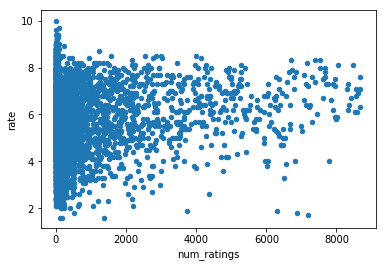

In [41]:
movies[movies.num_ratings < movies.num_ratings.quantile(.95)].plot(kind='scatter', x='num_ratings', y='rate')

Movie duration over time

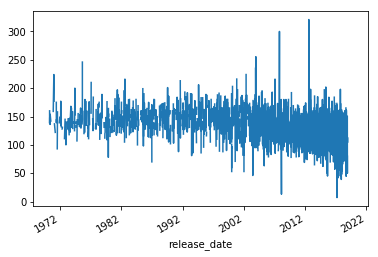

In [42]:
movies.set_index('release_date')['runtime'].plot()

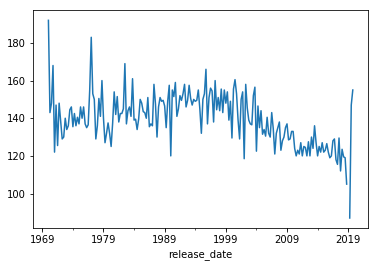

In [43]:
movies.set_index('release_date').resample('Q')['runtime'].median().plot()

In [44]:
movies.groupby('color')['runtime'].median()

color
Black and White    125.0
Color              133.0
Name: runtime, dtype: float64